In [25]:
import datetime as dt
import json
import warnings

import os

import numpy as np
import pandas as pd
from dataprep.eda import create_report
from scipy import stats
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

from pymongo import MongoClient

import warnings
warnings.filterwarnings("ignore")

from feature_engineering_functions import interdaily_stability, intradaily_variability, \
    social_jet_lag, sri, ISp, add_sleep_regularity_indices, get_mode_sleep_per_user, hour_diff

pd.set_option('display.max_rows', 100)

In [26]:
# Adding sleep startTime and endTime columns to the dataframe
def fitbit_intraday_sleep(df, db_name):
    # setup mongo connection for reading extra data
    with open('.\\..\\credentials.json') as f:
        data = json.load(f)
        username = data['username']
        password = data['password']
    client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password))
    db = client[db_name]
    col = db.fitbit

    # read intra-day data from Mongo
    df_mongo = pd.DataFrame(list(col.find({"$and": [
        {'type': 'sleep'},
        {'data.mainSleep': True}
    ]},
        {'_id': 0, 'id': 1, 'data.dateOfSleep': 1, 'data.startTime': 1, 'data.endTime': 1}
    )))
    df_mongo.loc[:, "date"] = df_mongo.data.str.get('dateOfSleep')
    df_mongo.loc[:, "startTime"] = df_mongo.data.str.get('startTime')
    df_mongo.loc[:, "endTime"] = df_mongo.data.str.get('endTime')
    df_mongo.drop(columns=['data'], inplace=True)
    df_mongo["date"] = pd.to_datetime(pd.to_datetime(df_mongo["date"]).dt.date)
    df = df.merge(df_mongo, how='left', on=['id', 'date'])
    return df

def sin_transform(values):
    return np.sin(2 * np.pi * values / len(set(values)))


def cos_transform(values):
    return np.cos(2 * np.pi * values / len(set(values)))

By calling the `add_sleep_regularity_indices()` function you add four types of regularity features w.r.t. sleep in the dataframe:
1. **Per-user Features** (i.e., `is_index`, `iv_index`, `sjl_index` and `sri_index`): These features describe sleep regularity and are taken from [this paper](https://academic.oup.com/sleep/article/44/10/zsab103/6232042?casa_token=UhbpbYN_5sEAAAAA:F-y_De1j7_KdF2K_Z12ztZR0_hGRtTrWEbl4K1Xz-77IN2TP9fkwAnO2kOUMFhQHMiJV-1FG96ZE4pU) and the [pyActigraphy library](https://ghammad.github.io/pyActigraphy/pyActigraphy-Non-parametric-variables.html). Each index value is calculated on a user-basis based on all data for each single user.
2. **Per-user Stats** (i.e., `mode_startTime_sin`, `mode_startTime_cos`, `mode_endTime_sin`, `mode_endTime_cos`): These features represent the most common (mode) sleep start and end time per user. They are transformed utilizing sin and cos transformations to capture the cyclic nature of time.
2. **Per-user-per-week Features** (i.e., `isp_index`): These features describe sleep regularity on a weekly basis, namely how different a user's week is compared to other weeks, and are taken from the [pyActigraphy library](https://ghammad.github.io/pyActigraphy/pyActigraphy-Non-parametric-variables.html). Each index value is calculated on a user- **AND week-basis** based on each week's data for each single user.
3. **Per-user-per-day Features** (i.e., `variability_startTime`, `variability_endTime`): These features describe how much a user's sleep schedule on a single date (row) deviates from their normal (mode) sleep schedule. Each variability value is calcvulated on a user- **AND day-basis** (one per row) based on each day's data for each single user.

Metrics/Indices that could be used for steps and exercise data are the following: `is_index`, `iv_index`, `sri_index`, and `isp_index` (with some adjustment).
After creating the eight files (four per metric), create a function like `add_sleep_regularity_indices()` for easy integration into the main dataframe.

# read from the database

In [27]:
# Connection to rais database
client = MongoClient('mongodb://host.docker.internal/mongo')
db = client.rais

In [28]:
number_of_steps = db.fitbit.find({"type": "steps"})

users=db.fitbit.distinct('id')

df = pd.DataFrame()

for user in users:
    user_data = list(db.fitbit.find({"id": user, "type": "steps"})) 

    # Create the 3 columns
    userId = []
    date = []
    steps = []
    for obj in user_data:
        d = obj["data"]
        date.append(d["dateTime"])
        steps.append(d["value"])
        userId.append(obj["id"])

    # Construct the dataframe
    data = {'date': date, 'id': userId, 'steps': steps} 
    user_df = pd.DataFrame(data)
    
    # Preprocessing 
    
    user_df['date'] = pd.to_datetime(user_df.date)
    user_df['steps'] = pd.to_numeric(user_df['steps'])
    user_df=user_df.resample('H', on='date').sum()
    user_df['id'] = obj['id']
    
    df = pd.concat([df, user_df]) 

In [29]:
df.to_pickle('../data/daily_hourly_fitbit_types/steps_hourly') 

# steps indices

In [46]:
steps = pd.read_pickle('../data/daily_hourly_fitbit_types/steps_hourly')

In [47]:
steps_IS_index = steps.groupby(['id']).apply(lambda data: interdaily_stability(data))
steps_IS_index = steps_IS_index.reset_index(drop=False)
steps_IS_index = steps_IS_index.rename(columns={0:'is_index', 'steps':'steps_is_index'})
steps_IS_index.head(10)

# 0 means totally regulary and 1 totally irregulary

,id,steps_is_index
0,621e2e8e67b776a24055b564,0.287117
1,621e2eaf67b776a2406b14ac,0.177255
2,621e2ed667b776a24085d8d1,0.160738
3,621e2ef567b776a24099f889,0.176704
4,621e2efa67b776a2409dd1c3,0.056705
5,621e2f1b67b776a240b3d87c,0.269479
6,621e2f3967b776a240c654db,0.227671
7,621e2f5767b776a240d8f9d6,0.254956
8,621e2f6167b776a240e082a9,0.135472
9,621e2f7a67b776a240f14425,0.195500


In [48]:
steps_IS_index.to_pickle('../data/steps_indices/steps_is_index')

In [49]:
steps_IV_index = steps.groupby(['id']).apply(lambda data: intradaily_variability(data))
steps_IV_index = steps_IV_index.reset_index(drop=False)
steps_IV_index = steps_IV_index.rename(columns={'steps':'steps_iv_index'})
steps_IV_index.head(10)

,id,steps_iv_index
0,621e2e8e67b776a24055b564,1.655374
1,621e2eaf67b776a2406b14ac,1.225664
2,621e2ed667b776a24085d8d1,1.428412
3,621e2ef567b776a24099f889,1.094834
4,621e2efa67b776a2409dd1c3,1.171121
5,621e2f1b67b776a240b3d87c,0.982040
6,621e2f3967b776a240c654db,1.434599
7,621e2f5767b776a240d8f9d6,1.106733
8,621e2f6167b776a240e082a9,1.258072
9,621e2f7a67b776a240f14425,0.766515


In [50]:
steps_IV_index.to_pickle('../data/steps_indices/steps_iv_index')

In [51]:
def listOfLists(lst):
    return [[el] for el in lst]

def flatten(t):
    return [item for sublist in t for item in sublist]

In [52]:
scaler = MinMaxScaler()
steps['steps'] = flatten(scaler.fit_transform(listOfLists(steps['steps'].to_numpy().tolist())))

<AxesSubplot:>

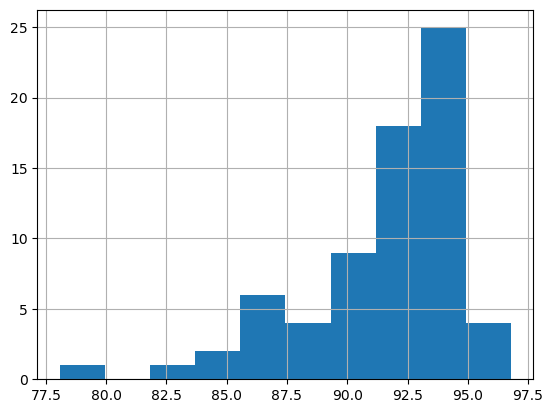

In [53]:
steps_sri_data = steps.groupby('id').apply(lambda user_data: sri(user_data.steps))
steps_sri_data.hist()

In [54]:
steps_sri_data = steps_sri_data.reset_index(drop=False)
steps_sri_data = steps_sri_data.rename(columns={0:'steps_sri_index'})
steps_sri_data.head()

,id,steps_sri_index
0,621e2e8e67b776a24055b564,89.963574
1,621e2eaf67b776a2406b14ac,82.772008
2,621e2ed667b776a24085d8d1,94.615195
3,621e2ef567b776a24099f889,90.682412
4,621e2efa67b776a2409dd1c3,94.241092


In [55]:
steps_sri_data.to_pickle('../data/steps_indices/steps_sri_index')

In [56]:
steps_ISp_index = steps.groupby(['id']).apply(lambda data: ISp(data, binarize=False, period='7D'))
steps_ISp_index = steps_ISp_index.reset_index(drop=False)
steps_ISp_index.loc[:, 'dates'] = steps_ISp_index.loc[:,0].apply(lambda row: row[-1])
steps_ISp_index.loc[:, 'data'] = steps_ISp_index.loc[:,0].apply(lambda row: row[:-1])
steps_ISp_index.drop(0, inplace=True, axis=1)
steps_ISp_index.head(10)


,id,dates,data
0,621e2e8e67b776a24055b564,"[(2021-05-24 00:00:00, 2021-05-31 00:00:00), (...","[[0.38110753151617166], [0.2881539105307654], ..."
1,621e2eaf67b776a2406b14ac,"[(2021-10-28 16:00:00, 2021-11-04 16:00:00), (...","[[0.3448085367241924], [0.2971883879313791], [..."
2,621e2ed667b776a24085d8d1,"[(2021-05-24 16:00:00, 2021-05-31 16:00:00), (...","[[0.18116454389665687], [0.18426249485943225],..."
3,621e2ef567b776a24099f889,[],[]
4,621e2efa67b776a2409dd1c3,"[(2021-05-24 00:00:00, 2021-05-31 00:00:00), (...","[[0.17361314872217445], [0.22227263991224733],..."
5,621e2f1b67b776a240b3d87c,"[(2021-11-06 11:00:00, 2021-11-13 11:00:00), (...","[[0.4504243209166006], [0.3887219880208618], [..."
6,621e2f3967b776a240c654db,"[(2021-05-24 01:00:00, 2021-05-31 01:00:00), (...","[[0.32294823137050177], [0.282963780101895], [..."
7,621e2f5767b776a240d8f9d6,"[(2021-11-14 13:00:00, 2021-11-21 13:00:00), (...","[[0.3498110067856353], [0.2741056639786796], [..."
8,621e2f6167b776a240e082a9,"[(2021-05-24 00:00:00, 2021-05-31 00:00:00), (...","[[0.25777831873365437], [0.3095641827185222], ..."
9,621e2f7a67b776a240f14425,"[(2021-05-24 00:00:00, 2021-05-31 00:00:00), (...","[[0.2159278298230782], [0.23493467594004133], ..."


In [57]:
def reformat_isp_result(ISp_index):
    users = set(ISp_index.id)
    users_isp = pd.DataFrame()
    for row in tqdm(range(len(users))):
        user = ISp_index.iloc[row, :]
        user_df = pd.DataFrame()
        if len(user.dates) == 0:
            continue
        user_df.loc[:, "date"] = user.dates
        user_df.loc[:, "id"] = user.id
        user_df.loc[:, "data"] = user.data
        user_df.loc[:, "startDate"] = pd.to_datetime(user_df.date.apply(lambda d: d[0]))
        user_df.loc[:, "endDate"] =  pd.to_datetime(user_df.date.apply(lambda d: d[1]))
        user_df.drop('date', inplace=True, axis=1)
        user_df.data = pd.Series(user_df.data).astype(float)
        users_isp = users_isp.append(user_df)
    users_isp = users_isp.rename(columns={"data": "isp_index"})
    return users_isp

In [58]:
steps_users_isp = reformat_isp_result(steps_ISp_index)
steps_users_isp

100%|█████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 251.35it/s]


,id,isp_index,startDate,endDate
0,621e2e8e67b776a24055b564,0.381108,2021-05-24,2021-05-31
1,621e2e8e67b776a24055b564,0.288154,2021-05-31,2021-06-07
2,621e2e8e67b776a24055b564,0.331709,2021-06-07,2021-06-14
3,621e2e8e67b776a24055b564,0.406876,2021-06-14,2021-06-21
4,621e2e8e67b776a24055b564,0.334966,2021-06-21,2021-06-28
...,...,...,...,...
5,621e375b67b776a240290cdc,0.618363,2021-06-28,2021-07-05
6,621e375b67b776a240290cdc,0.214846,2021-07-05,2021-07-12
7,621e375b67b776a240290cdc,0.277138,2021-07-12,2021-07-19
8,621e375b67b776a240290cdc,0.371521,2021-07-19,2021-07-26


In [59]:
#steps_users_isp = steps_users_isp.drop(columns=['startDate', 'endDate'])
steps_users_isp = steps_users_isp.rename(columns={'isp_index':'steps_isp_index'})
steps_users_isp

,id,steps_isp_index,startDate,endDate
0,621e2e8e67b776a24055b564,0.381108,2021-05-24,2021-05-31
1,621e2e8e67b776a24055b564,0.288154,2021-05-31,2021-06-07
2,621e2e8e67b776a24055b564,0.331709,2021-06-07,2021-06-14
3,621e2e8e67b776a24055b564,0.406876,2021-06-14,2021-06-21
4,621e2e8e67b776a24055b564,0.334966,2021-06-21,2021-06-28
...,...,...,...,...
5,621e375b67b776a240290cdc,0.618363,2021-06-28,2021-07-05
6,621e375b67b776a240290cdc,0.214846,2021-07-05,2021-07-12
7,621e375b67b776a240290cdc,0.277138,2021-07-12,2021-07-19
8,621e375b67b776a240290cdc,0.371521,2021-07-19,2021-07-26


In [60]:
steps_users_isp.to_pickle('../data/steps_indices/steps_isp_index')

------------
# Merge with the dataframe

In [61]:
data = pd.read_pickle('../data/unified_dataframe/data_preprocessed.pkl')
data.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Steps_hour14,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,...,191.0,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
2,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
3,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,35.216,95.9,14.6,84.0,0.966667,0.725,...,85.0,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0
4,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,35.216,95.9,14.8,82.0,0.933333,0.725,...,58.0,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0


In [80]:
def add_steps_regularity_indices(data): 
    dir = "../data/steps_indices/"

    data.date = pd.to_datetime(data.date)  # convert to datetime
    # indices
    users_is = pd.read_pickle(os.path.join(dir, "steps_is_index.pkl"))
    users_isp = pd.read_pickle(os.path.join(dir, "steps_isp_index.pkl"))
    users_iv = pd.read_pickle(os.path.join(dir, "steps_iv_index.pkl"))
    users_sri = pd.read_pickle(os.path.join(dir, "steps_sri_index.pkl"))

    merged = data.merge(users_is, on='id', how='left')
    merged = merged.merge(users_iv, on='id', how='left')
    merged = merged.merge(users_sri, on='id', how='left')

    # add ISP per week
    merged = merged.merge(users_isp, how='left', left_on=['id', 'date'], right_on=['id', 'startDate'])
    merged = merged.sort_values(by=['id', 'date'])
    merged.isp_index = merged.isp_index.ffill(limit=6)

    merged.drop(['startDate', 'endDate'], axis=1, inplace=True)

    return merged

In [81]:
add_steps_regularity_indices(data)

FileNotFoundError: [Errno 2] No such file or directory: '../data/steps_indices/steps_is_index.pkl'